## <font color="green">**_Introduction to DAS Data_**  
### <font color="green"> --> Introduction to the XDAS package for loading, processing, and plotting</font>
<font color="green"> The Notebooks here are divided into several steps: </font>

<font color="green"> - 01_load_and_visualize.ipynb </font>

<font color="green"> - 02_signal_processing.ipynb </font>

<font color="green"> - 03_more_tools.ipynb </font>
</font>

In [1]:
#-- Import common packages
import numpy as np
import xdas as xd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta


from custom_util import apply_mapping, apply_scaling

## <font color="green"> Open the data.
<font color="green"> XDAS at first only "virtually" opens files. Loading all the data from all the channels for the entire time window would be too much memory; your computer will crash. It first scans the directory to load headers (times, distances), and later we can subselect smaller snippets to process and visualize.</font>

In [2]:
data = xd.open_mfdataarray('./DAS_Data_Skience2025/Athens/Earthquakes/20211012/*nc')
print(data)

<xdas.DataArray (time: 180000, distance: 12416)>
VirtualStack: 4.2GB (int16)
Coordinates:
  * time (time): 2021-10-12T09:00:00.001 to 2021-10-12T09:59:59.981
  * distance (distance): -264.380 to 25085.858


<font color="green">Above, we see the "VirtualStack" of 4.2GB. This *might* fit into some of our computer's memory, but... 
</br>

<font color="green"> - this folder is only 1 hour of data instead of an entire experiment (e.g. 1 month), 
</br>

<font color="green"> - it's already downsampled to 50 Hz (e.g. instead of the original 400 Hz). 

<font color="green"> The raw dataset for Athens is ~30TB. The ability to only "virtually" look at this is important!</font>

---
## <font color="green"> Load time with an Earthquake! </font>

<font color="green">Let's select a time window when there should be an earthquake:
https://www.emsc.eu/Earthquake_information/earthquake.php?id=1047368 


<font color="green">We'll subselect that time and load only that part.</font>

In [3]:
#-- .sel() allows to subselect from time= or distance=
earthquake = data.sel(time=slice("2021-10-12T09:24:30", "2021-10-12T09:28:00"))

#-- .load() allows us to actually load the array into memory
earthquake = earthquake.load()

print(earthquake)

<xdas.DataArray (time: 10500, distance: 12416)>
[[-147  -27  158 ... -554 -898 -955]
 [-332 -573 -456 ... -412 -608 -395]
 [ 734  546  366 ...   21  260  831]
 ...
 [-470 -648 -765 ...  123  125 -110]
 [-194 -243 -412 ...  580  639   83]
 [ 825  896  836 ...  193  219   82]]
Coordinates:
  * time (time): 2021-10-12T09:24:30.001 to 2021-10-12T09:27:59.981
  * distance (distance): -264.380 to 25085.858



<font color="green">We can also see the attached "time" and "distance" axes. 

<font color="green"> The variable data refers to a custum object which contains the data as an xarray (wrapped numpy array), and a dict() of coordinates for time and distance.</font>

In [4]:
#-- We can examine the pieces of the object separately, as numpy arrays at the lowest level
print("das data values")
print(earthquake.values)
print("------------")
print("time axis")
print(earthquake.coords['time'].values)
print("------------")
print("distance axis")
print(earthquake.coords['distance'].values)

das data values
[[-147  -27  158 ... -554 -898 -955]
 [-332 -573 -456 ... -412 -608 -395]
 [ 734  546  366 ...   21  260  831]
 ...
 [-470 -648 -765 ...  123  125 -110]
 [-194 -243 -412 ...  580  639   83]
 [ 825  896  836 ...  193  219   82]]
------------
time axis
['2021-10-12T09:24:30.001083000' '2021-10-12T09:24:30.021083000'
 '2021-10-12T09:24:30.041083000' ... '2021-10-12T09:27:59.941083000'
 '2021-10-12T09:27:59.961083000' '2021-10-12T09:27:59.981083000']
------------
distance axis
[ -264.38      -262.338096  -260.296192 ... 25081.774352 25083.816256
 25085.85816 ]


<font color="green">The values there are of "optical intensity", which is basically meaningless to us. This varies by DAS interrogator manufacturer. For this Silixa iDAS system, we can convert to physically meaningful units of strain-rate [m/m]/s with the following: </font>

In [5]:
#-- Instrument response / convert units
earthquake = earthquake * 116.0 / 8192.0 * 400.0 / 10.0 * 1e-9

---
## <font color="green"> Plot it! </font>

<font color="green"> A neat thing about XDAS is that there are many tools built in. One of which is for plotting.

<font color="green"> Under the hood it's using the X-array implementation of imshow(), which under the hood is just a call to matplotlib's .imshow(). That means many of the arguments you might pass to matplotlib are the same. Here we'll use "vmin" and "vmax" to specify the range of the colorscale</font>

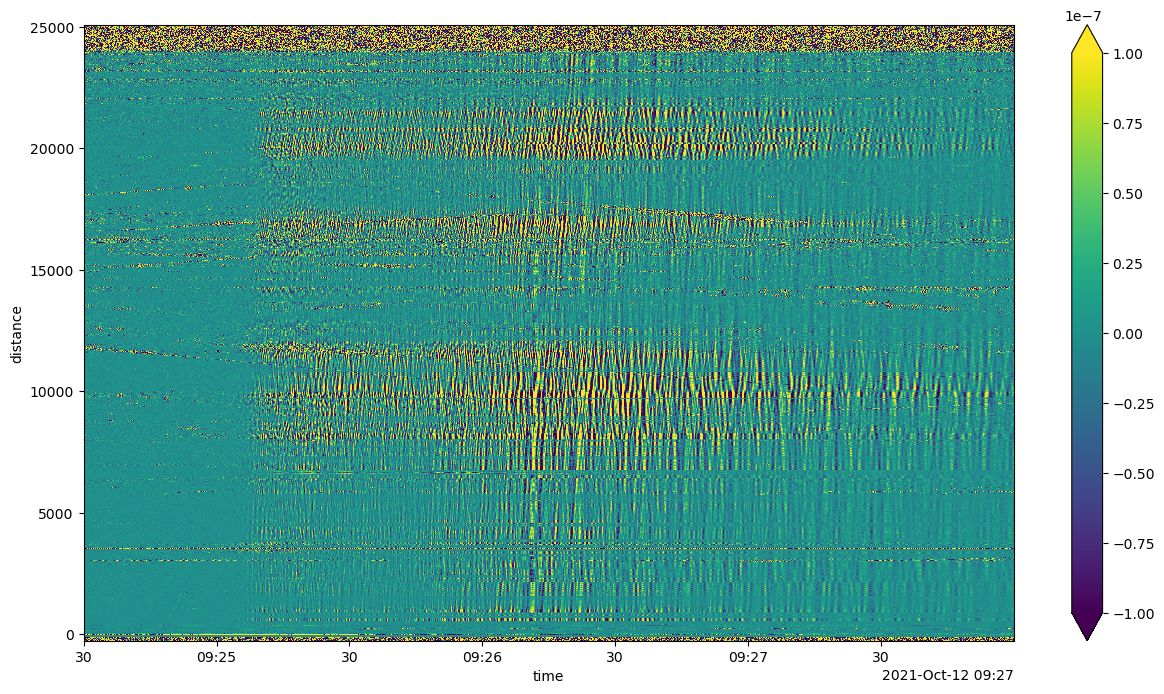

In [6]:
plt.figure(figsize=(15,8))
ax = plt.gca()
earthquake.plot(x="time",ax=ax,vmin=-100e-9,vmax=100e-9) 

<font color="green">Again, we can also directly access the data as a numpy array. This means we could define our own plotting function for more fine-tuned control (e.g. axis labels, tickmarks, etc.)</font>

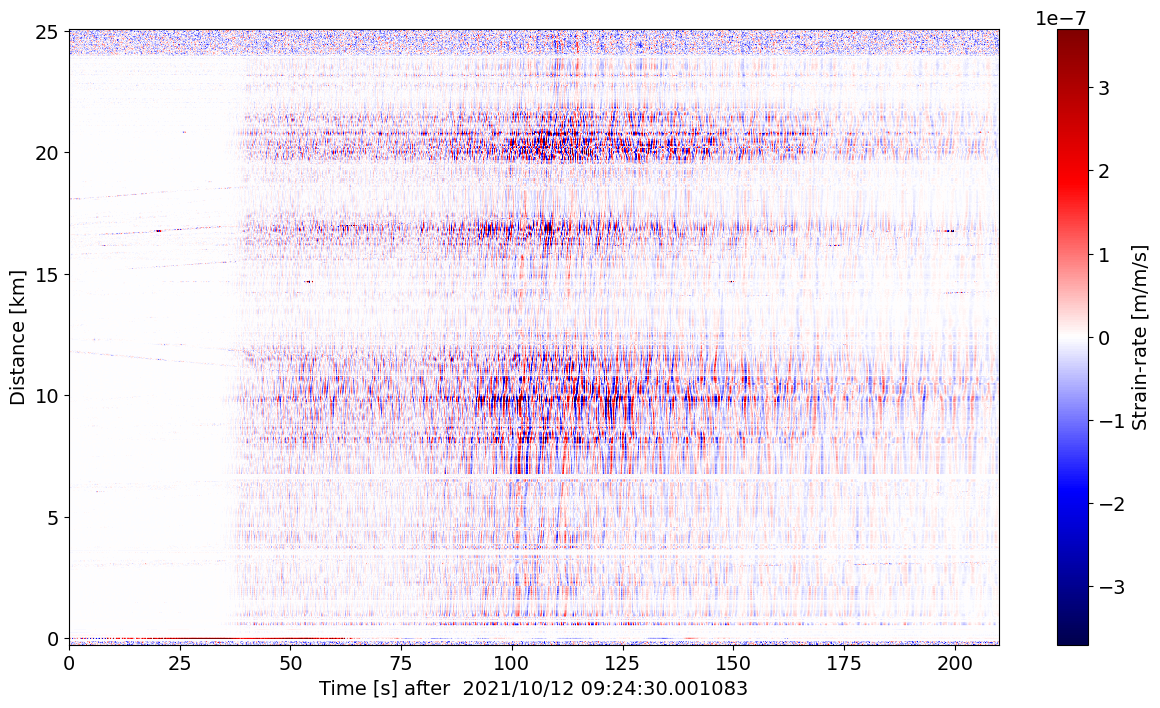

In [7]:

plt.rcParams.update({'font.size': 14})

plt.figure(figsize=(15,8))
ax = plt.gca()

#-- Work out the bounds of the plot
t0 = datetime.strptime(earthquake.coords['time'][0].to_dict()['data'] ,'%Y-%m-%dT%H:%M:%S.%f000')
t1 = datetime.strptime(earthquake.coords['time'][-1].to_dict()['data'],'%Y-%m-%dT%H:%M:%S.%f000')
t0sec = 0
t1sec = (t1-t0).total_seconds()

d0 = earthquake.coords['distance'][0].to_dict()['data']
d1 = earthquake.coords['distance'][-1].to_dict()['data']

#-- Colorbar range will be +/- 10 times the mean value
vlim = np.mean(np.abs(earthquake.data))*10

#-- Actual imshow() call 
#--  (note that the xarray implementation from xdas is *slightly* different than direct matplotlib)
plt.imshow(earthquake.T, aspect="auto", cmap='seismic', interpolation='antialiased', 
        extent=(t0sec,t1sec, d1/1000.0,d0/1000),
        vmin=-vlim, vmax=vlim)

plt.colorbar(label="Strain-rate [m/m/s]")
plt.xlabel("Time [s] after  "+ datetime.strftime(t0, format='%Y/%m/%d %H:%M:%S.%f'))
plt.ylabel("Distance [km]")
ax.invert_yaxis()

# plt.savefig("example.png",bbox_inches="tight")
plt.show()


---
## <font color="green"> Apply Channel Mapping </font>

<font color="green"> When we plugged in to the fiber provided by the telecom company OTE in Athens, they gave us a rough map of where the fiber went.

<font color="green">- It wasn't 100% accurate / didn't specify which side of the street it would be on, or if the fiber went into a junction box on the side of the road.


<font color="green"> - We had no idea what distances corresponded to the lat/lon points. If 50 meters of fiber was bundled up in a junction, we needed to know.


<font color="green">"Tap testing" included driving around the lenght of the line and smacking the ground with a sledehammer to see where in the DAS data signals appeared. This let us define a set of "tie points" where the lat/lon is matched with a channel number.

<font color="green">This was saved in a text file called "segments.txt" and can be loaded into the XDas format such that the XDas objects hold more precise distances, exclude bad unlocated channels, and carry along lat/lon coordinates. Working with the text file was messy so that code is in a separate *.py file "custom_util.py"; these are not XDas functions but just scripts included for this dataset. (It's also very inefficient.)

</font>

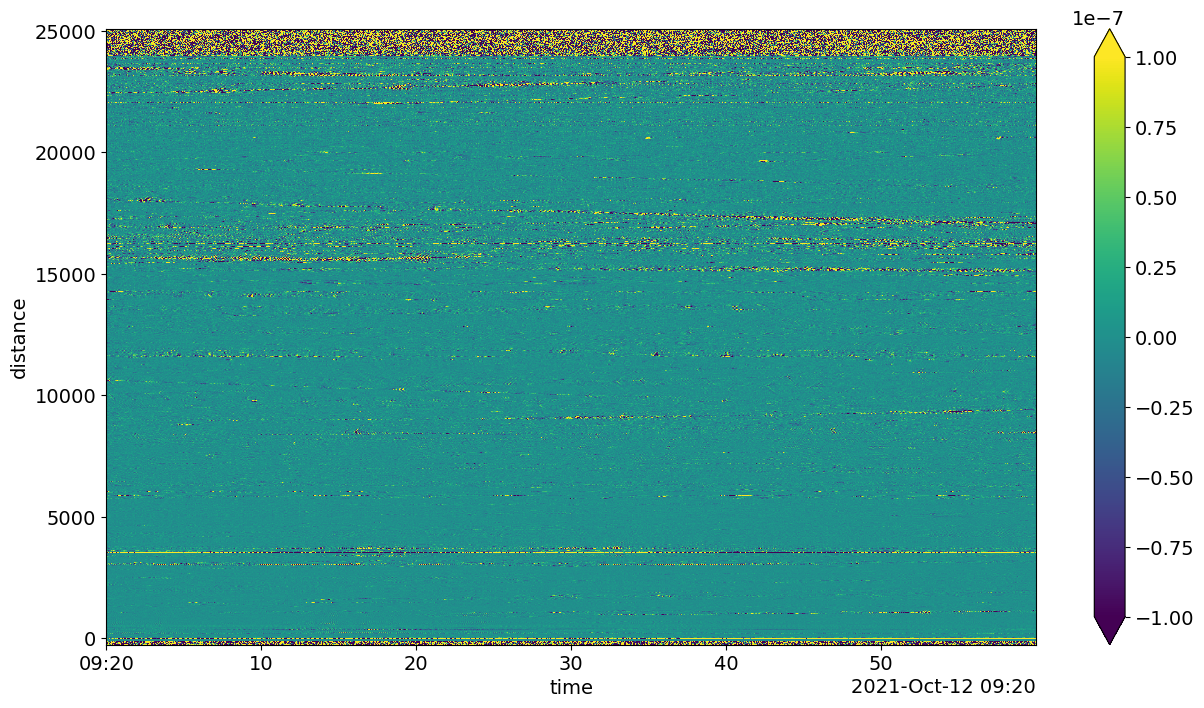

In [8]:
#-- We'll look at a time other than the earthquake, just for an example
subset = data.sel(time=slice("2021-10-12T09:20:00", "2021-10-12T09:21:00"))

#-- apply_scaling just wraps up that conversion to strain-rate units.
subset = apply_scaling(subset)

plt.figure(figsize=(15,8))
ax = plt.gca()
subset.plot(x="time",ax=ax,vmin=-100e-9,vmax=100e-9) 

In [9]:
#-- apply_mapping trims out the bad / unlocated channels, and attaches the updated coordinates
subset = apply_mapping(subset)


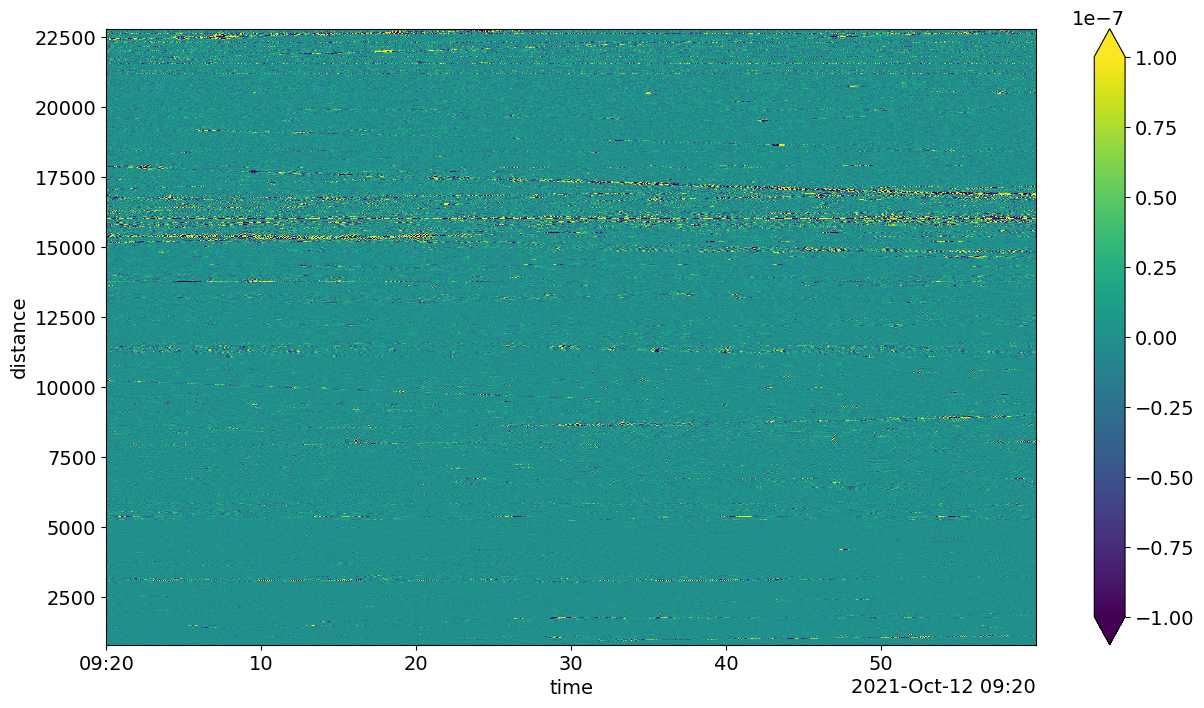

In [10]:
plt.figure(figsize=(15,8))
ax = plt.gca()
subset.plot(x="time",ax=ax,vmin=-100e-9,vmax=100e-9) 

<font color="green">
We see that the whole thing looks cleaner! We removed some of the bad channels, as well as cut off the end.

</br>

Additionally we can see that the XDas object "subset" now also contains lat / lon information
</fond> 

In [11]:
print(subset)
print('-----')


print(subset.coords['distance'].values)

<xdas.DataArray (time: 3000, distance: 10401)>
[[ 1.699219e-09  1.132813e-09  5.664063e-10 ...  6.796875e-09
   1.302734e-08  2.435547e-08]
 [ 1.132813e-09  0.000000e+00  0.000000e+00 ...  9.062500e-09
   6.230469e-09  1.302734e-08]
 [-5.664063e-10 -5.664063e-10  0.000000e+00 ... -1.132813e-09
  -3.398438e-09 -5.664063e-09]
 ...
 [-1.699219e-09 -5.664063e-10  0.000000e+00 ... -6.796875e-08
  -7.816406e-08 -9.119141e-08]
 [ 1.132813e-09  0.000000e+00  1.132813e-09 ... -5.664063e-10
  -1.869141e-08 -4.248047e-08]
 [ 2.832031e-09  1.699219e-09  0.000000e+00 ...  7.023438e-08
   5.890625e-08  4.757813e-08]]
Coordinates:
  * time (time): 2021-10-12T09:20:00.001 to 2021-10-12T09:20:59.981
  * distance (distance): 810.000 to 22805.000
    latitude (distance): 38.049 to 38.185
    longitude (distance): 23.788 to 23.854
-----
[  810.           812.05         814.1        ... 22800.90772386
 22802.95386193 22805.        ]


---
## <font color="blue"> Exercise: 
#### <font color="blue"> Plot a map of the fiber layout
